In [1]:
import RtKernel as ker
import RtDlr as dlr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    "font.size" : 8
})

In [183]:
beta = 20
N_max = 50
delta_t = 0.1
upper_cutoff = 200
lower_cutoff = 1.e-1
phi = np.pi/4
#set the values of m that should be explored
#h_vals = np.logspace(start=-2, stop=-1, num=10, base=10.0)[::-1]#time steps to explore
h_vals = np.log(np.arange(2,1.,-0.05))

Set frequency grid such that discrete integral is converged in m and n up to relative error epsilon (defined in cell below)

In [193]:
#compute continuous integral results
times = ker.set_time_grid(N_max, delta_t = delta_t)#time grid up to maximal time used
cont_integral = np.array([ker.cont_integral(t, beta, upper_cutoff) for t in times])#array containing all values for the continuous integration result

discr_vals = np.zeros((len(h_vals), len(times)), dtype=np.complex_)
errors = np.zeros((len(h_vals)))
m_vals = np.zeros((len(h_vals)), dtype=np.int_)
n_vals = np.zeros((len(h_vals)), dtype=np.int_)

nbr_iterations = 0#count number of iterations for which the loop through h

for i,h in enumerate(np.concatenate((h_vals[:3],h_vals[-3:]))):
    nbr_iterations += 1

    #initialize m and n
    m_init = int(10. / h)
    n_init = int(5. / h)
    
    m = m_init
    n = n_init
    #discrete integral approximation for large m and n, i.e. the error is solely due to finite h and not due to finite m and n
    discr_integral_0 = np.array([ker.DiscrError(m_init, n_init, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

    #compute the error for very large m and n. In the following this will be used as epsilon, to estimate optimal m and n
    err = ker.DiscrError(m,n,N_max,delta_t,beta,upper_cutoff, h = h).error_time_integrated(time_series_exact=cont_integral, time_series_approx=discr_integral_0)
    
    if (i>0 and err > err) or err < 1.e-9:
        print('Attention: Either error does not shrink with h (problem with Finite m, n?) or error smaller than 10.e-10.')
        break
    
    else:
        errors[i] = err
        
    epsilon = 1.e-2 * errors[i]#define error for estimate of m and n as this. Like this, the global error is guaranteed to be dominated by the effect from finite h and not from finite m or n.

    vary_m = True
    vary_n = True
    
    while vary_m:
        m -= 1
        # Evaluate DiscrError for varying m and n_init
        discr_integral_current = np.array([ker.DiscrError(m, n_init, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

        # Check if the error differs by more than epsilon
        rel_val_diff = abs(np.sum(discr_integral_current - discr_integral_0))/abs(np.sum(discr_integral_0))
        if rel_val_diff > epsilon:
            # If the value differs, halt iteration through m 
            #restore previous m
            m += 1
            #discr_vals[i,:] = np.array([ker.DiscrError(m, n_init, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])
            m_vals[i] = m
            
            break
 

    while vary_n:
        n -= 1
        # Evaluate DiscrError for m_init and varying n
        discr_integral_current = np.array([ker.DiscrError(m_init, n, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

        # Check if the error differs by more than epsilon
        rel_val_diff = abs(np.sum(discr_integral_current - discr_integral_0))/abs(np.sum(discr_integral_0))
        if rel_val_diff > epsilon:
            # If the value differs, fix the current values of n
            #discr_vals[i,:] = np.array([ker.DiscrError(m_init, n, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])
            #restore previous n
            n += 1
            n_vals[i] = n
            break 
    

Compute interpolative decomposition for errors determined in cell above

In [185]:
#compute ID and SVD
D =  np.array([dlr.RtDlr(N_max, delta_t, beta, upper_cutoff, m_vals[i], n_vals[i], eps = errors[i], h = h) for i,h in enumerate(h_vals)])

In [186]:
#Compute the time-integrated error between the original Green's function and the reconstructed Green's function for all values of h.
propagator_reconstr, propagator_errors = zip(
    *[d.reconstruct_propag(compute_error=True) for d in D]
)

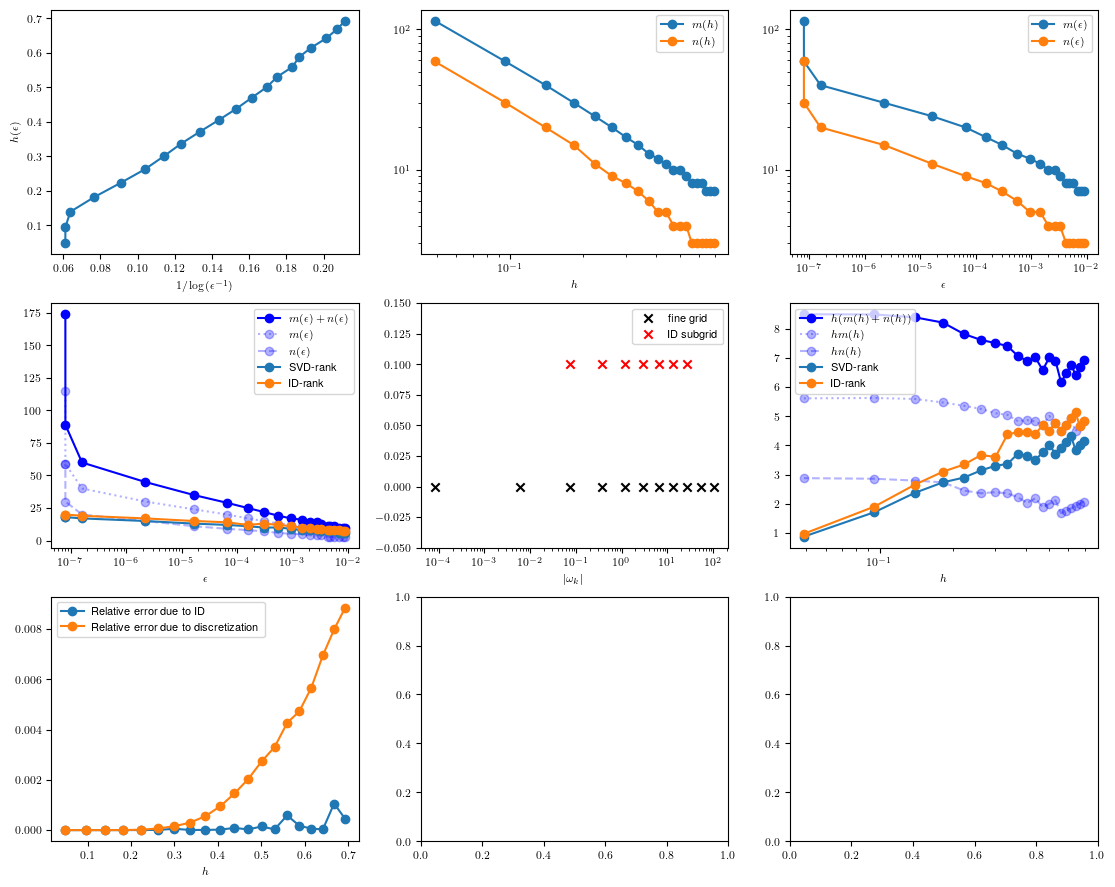

In [187]:
fig, axs = plt.subplots(3, 3, figsize=(13.5,10.8)) 

axs[0,0].plot(1/np.log(1/errors), h_vals, marker='o', linestyle='-')
axs[0,0].set_xlabel(r'$1/\log(\epsilon^{-1})$')
axs[0,0].set_ylabel(r'$h(\epsilon)$')
#axs[0,0].legend()

axs[0,1].plot(h_vals, m_vals, label = r'$m(h)$', marker='o', linestyle='-')
axs[0,1].plot(h_vals, n_vals, label = r'$n(h)$', marker='o', linestyle='-')
axs[0,1].set_xlabel(r'$h$')
axs[0,1].legend()
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[0,2].plot(errors, m_vals, label = r'$m(\epsilon)$', marker='o', linestyle='-')
axs[0,2].plot(errors, n_vals, label = r'$n(\epsilon)$', marker='o', linestyle='-')
axs[0,2].set_xlabel(r'$\epsilon$')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()



axs[1,0].plot(errors,m_vals + n_vals, color = 'blue', label=r'$m(\epsilon) + n(\epsilon)$', marker='o', linestyle='-')
axs[1,0].plot(errors,m_vals, color = 'blue', label=r'$m(\epsilon)$', alpha = 0.3, linestyle = 'dotted', marker='o')
axs[1,0].plot(errors,n_vals, color = 'blue', label=r'$n(\epsilon)$', alpha = 0.3, linestyle = 'dashed', marker='o')
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[1,0].plot(errors,num_sing_vals,  label= 'SVD-rank', marker='o', linestyle='-')
ID_rank = np.array([d.ID_rank for d in D])
axs[1,0].plot(errors,ID_rank,  label= 'ID-rank', marker='o', linestyle='-')
axs[1,0].set_xlabel(r'$\epsilon$')
axs[1,0].legend()
axs[1,0].set_xscale('log')

fine_grid = D[1].fine_grid # fine grid at some index, here chosen to be len(D)//2
coarse_grid = D[1].coarse_grid # coarse grid at some index, here chosen to be len(D)//2
axs[1,1].scatter(fine_grid,len(fine_grid) * [0], color = 'black', label = 'fine grid', marker='x')
axs[1,1].scatter(coarse_grid,len(coarse_grid) * [0.1],  color = 'red', label = 'ID subgrid', marker='x')
axs[1,1].set_ylim(bottom = -0.05, top = 0.15)
#axs[1,1].set_xlim(left = 1.e-2, right = 70)
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$|\omega_k|$')
axs[1,1].legend()


axs[1,2].plot(h_vals,h_vals*(m_vals + n_vals), color = 'blue', label=r'$h(m(h) + n(h))$', marker='o', linestyle='-')
axs[1,2].plot(h_vals,h_vals*m_vals, color = 'blue', label=r'$h m(h)$', alpha = 0.3, linestyle = 'dotted', marker='o')
axs[1,2].plot(h_vals,h_vals*n_vals, color = 'blue', label=r'$hn(h)$', alpha = 0.3, linestyle = 'dashed', marker='o')
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[1,2].plot(h_vals,h_vals*num_sing_vals,  label= 'SVD-rank', marker='o', linestyle='-')
ID_rank = np.array([d.ID_rank for d in D])
axs[1,2].plot(h_vals,h_vals*ID_rank,  label= 'ID-rank', marker='o', linestyle='-')
axs[1,2].set_xlabel(r'$h$')
axs[1,2].legend()
axs[1,2].set_xscale('log')


axs[2,0].plot(h_vals, propagator_errors, label = 'Relative error due to ID', marker='o', linestyle='-')
axs[2,0].plot(h_vals, errors, label = 'Relative error due to discretization', marker='o', linestyle='-')
axs[2,0].set_xlabel(r'$h$')
#axs[2,0].set_yscale('log')
#axs[2,0].set_xscale('log')
axs[2,0].legend()

plt.savefig('./plots/overview_exp.pdf')